
This is an interactive tutorial designed to walk through
regularization for a linear-Gaussian GLM, which allows for closed-form
MAP parameter estimates.  The next tutorial ('tutorial4') will cover the
same methods for the Poisson GLM (which requires numerical optimization).

We'll consider two simple regularization methods:

1. Ridge regression - corresponds to maximum a posteriori (MAP) estimation under an iid Gaussian prior on the filter coefficients. 

2. L2 smoothing prior - using to an iid Gaussian prior on the pairwise-differences of the filter(s).

Data: from Uzzell & Chichilnisky 2004; see README file for details. 

Last updated: Mar 10, 2020 (JW Pillow)

Tutorial instructions: Execute each section below separately using
cmd-enter. For detailed suggestions on how to interact with this
tutorial, see header material in tutorial1_PoissonGLM.m

Modified into Python by Xiaodong LI

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import hankel,pinv,block_diag
from scipy.interpolate import interp1d
from interpolation import interp
from numpy.linalg import inv,norm,lstsq
from matplotlib import mlab
aa=np.asarray

# Load the raw data

Be sure to unzip the data file data_RGCs.zip
(http://pillowlab.princeton.edu/data/data_RGCs.zip) and place it in 
this directory before running the tutorial.  
Or substitute your own dataset here instead!


(Data from Uzzell & Chichilnisky 2004):

In [3]:
datadir='../data_RGCs/' # directory where stimulus lives
Stim=loadmat(datadir+'Stim.mat')['Stim'].flatten() # stimulus (temporal binary white noise)
stimtimes=loadmat(datadir+'stimtimes.mat')['stimtimes'].flatten() # stim frame times in seconds (if desired)
SpTimes=loadmat(datadir+'SpTimes.mat')['SpTimes'][0,:] # load spike times (in units of stim frames)
ncells=len(SpTimes) # number of neurons (4 for this dataset).
# Neurons #0-1 are OFF, #2-3 are ON.

Pick a cell to work with

In [4]:
cellnum = 2 # (0-1 are OFF cells; 2-3 are ON cells).
tsp = SpTimes[cellnum]

Compute some basic statistics on the stimulus

In [6]:
dtStim = stimtimes[1]-stimtimes[0] # time bin size for stimulus (s)

# See tutorial 1 for some code to visualize the raw data!

# Upsample to get finer timescale representation of stim and spikes

The need to regularize GLM parameter estimates is acute when we don't
have enough data relative to the number of parameters we're trying to
estimate, or when using correlated (eg naturalistic) stimuli, since the
stimuli don't have enough power at all frequencies to estimate all
frequency components of the filter. 

The RGC dataset we've looked at so far requires only a temporal filter
(as opposed to spatio-temporal filter for full spatiotemporal movie
stimuli), so it doesn't have that many parameters to esimate. It also has
binary white noise stimuli, which have equal energy at all frequencies.
___Regularization thus isn't an especially big deal for this data___ (which was
part of our reason for selecting it). However, we can make it look
correlated by considering it on a finer timescale than the frame rate of
the monitor.  (Indeed, this will make it look highly correlated).

For speed of our code and to illustrate the advantages of regularization,
let's use only a reduced (5-minute) portion of the dataset:

In [8]:
nT=120*60*1 # number of time bins for 1 minute of data
Stim=Stim[:nT] # pare down stimulus
tsp=tsp[tsp<nT*dtStim] # pare down spikes

Now upsample to finer temporal grid

In [9]:
upsampfactor = 10 # divide each time bin by this factor
dtStimhi = dtStim/upsampfactor # use bins 100 time bins finer
ttgridhi = np.arange(dtStimhi/2,nT*dtStim+dtStimhi,dtStimhi) # fine time grid for upsampled stim
Stimhi = interp1d(np.arange(1,nT+1)*dtStim,Stim,kind='nearest',fill_value='extrapolate')(ttgridhi)
nThi = nT*upsampfactor  # length of upsampled stimulus

Visualize the new (upsampled) raw data:

<ipython-input-22-97db7153fd27>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(ttplot,sps[iiplot])


(0.0, 0.49960223949999993)

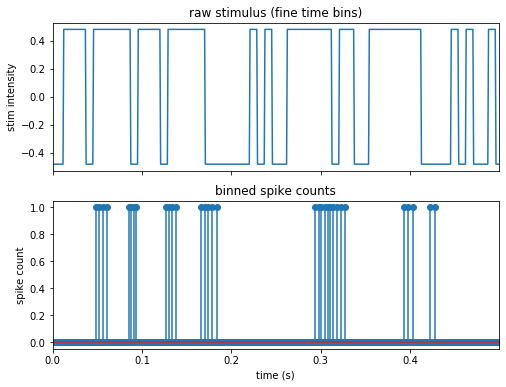

In [22]:
fig,axes=plt.subplots(nrows=2,figsize=(8,6),sharex=True)
iiplot=np.arange(0,60*upsampfactor) # bins of stimulus to plot
ttplot=iiplot*dtStimhi # time bins of stimulus
axes[0].plot(ttplot,Stimhi[iiplot])
axes[0].set_title('raw stimulus (fine time bins)')
axes[0].set_ylabel('stim intensity')
# Should notice stimulus now constant for many bins in a row
sps,_=np.histogram(tsp,ttgridhi) # Bin the spike train and replot binned counts
axes[1].stem(ttplot,sps[iiplot])
axes[1].set_title('binned spike counts')
axes[1].set_ylabel('spike count')
axes[1].set_xlabel('time (s)')
axes[1].set_xlim(ttplot[0],ttplot[-1])

# Divide data into "training" and "test" sets for cross-validation

In [33]:
trainfrac = .8  # fraction of data to use for training
ntrain = int(np.ceil(nThi*trainfrac))  # number of training samples
ntest = int(nThi-ntrain) # number of test samples
iitest = np.arange(ntest).astype(int) # time indices for test
iitrain = np.arange(ntest,nThi).astype(int)   # time indices for training
stimtrain = Stimhi[iitrain] # training stimulus
stimtest = Stimhi[iitest] # test stimulus
spstrain = sps[iitrain]
spstest =  sps[iitest]

print('Dividing data into training and test sets:\n')
print('Training: %d samples (%d spikes) \n'%(ntrain, sum(spstrain)))
print('    Test: %d samples (%d spikes)\n'%(ntest, sum(spstest)))

Dividing data into training and test sets:

Training: 57600 samples (2109 spikes) 

    Test: 14400 samples (557 spikes)



# Fit the linear-Gaussian model using ML

Set the number of time bins of stimulus to use for predicting spikes

In [64]:
ntfilt = 20*upsampfactor # Try varying this, to see how performance changes!

build the design matrix, training data

In [65]:
Xtrain = np.c_[
    np.ones((ntrain,1)),
    hankel(np.r_[np.zeros(ntfilt-1),stimtrain[:-ntfilt+1]].reshape(-1,1),stimtrain[-ntfilt:])]

Compute maximum likelihood filter estimate ("whitened STA")

<ipython-input-66-e6bcd07c886f>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  filtML=lstsq(Xtrain.T@Xtrain,Xtrain.T@spstrain)[0]


Text(0.5, 0, 'time before spike')

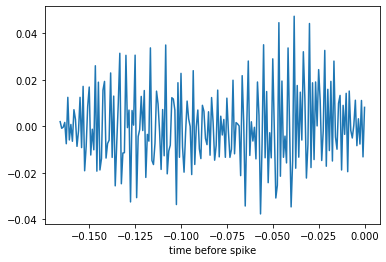

In [66]:
filtML=lstsq(Xtrain.T@Xtrain,Xtrain.T@spstrain)[0]
ttk=np.arange(-ntfilt+1,1,1)*dtStimhi
fig,axes=plt.subplots()
axes.plot(ttk,filtML[1:])
axes.set_xlabel('time before spike')

Looks like garbage! If you reduce 'upsampfactor' to 2, it still looks ok,
but beyond this the stimulus lacks support at high frequencies and the
covariance `Xdsgn.T@Xdsgn` becomes badly conditioned.

# Ridge regression: linear-Gaussian model

Now let's regularize by adding a penalty on the sum of squared filter
coefficients w(i) of the form:   
      
      penalty(lambda_) = lambda_*(sum_i w(i)**2),

where lambda_ is known as the "ridge" parameter.  This is also known as an
"L2 penalty".  Minimizing error plus this penalty ("penalized least
squares") is equivalent to computing the MAP estimate under an iid
Gaussian prior on the filter coefficients.  

The MAP estimate for the LG model parameters has a closed form, making it
simple and fast to compute: 
    
    w_hat = (X.T@X + lambda_@I)**(-1) @ X**T@Y 

The only remaining question is: how to set lambda_?
We'll show here how to do it for a grid of lambda_ values and use
cross-validation (test error) to select which is best.  

Set up grid of lambda_ values (ridge parameters)

In [67]:
lamvals = 2.**np.arange(0,16) # it's common to use a log-spaced set of values, penalty value
nlam = len(lamvals)

Build design matrix for test data

In [68]:
Xtest = np.c_[
    np.ones((ntest,1)),
    hankel(np.r_[np.zeros(ntfilt-1),stimtest[:-ntfilt+1]].reshape(-1,1),stimtest[-ntfilt:])]

Precompute some quantities (`X.T@X` and `X.T@y`) for training and test data

In [69]:
XXtr = Xtrain.T@Xtrain
XYtr = Xtrain.T@spstrain # spike-triggered average, training data
Imat = np.eye(ntfilt+1) # identity matrix of size of filter + const
Imat[0,0] = 0 # don't apply penalty to constant coeff

Allocate space for train and test errors

In [75]:
msetrain = np.zeros(nlam) # training error
msetest = np.zeros(nlam) # test error
w_ridge = np.zeros((ntfilt+1,nlam)) # filters for each lambda

Now compute MAP estimate for each ridge parameter

<ipython-input-78-3a03e89a5fe6>:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = lstsq(XXtr+lamvals[jj]*Imat,XYtr)[0]


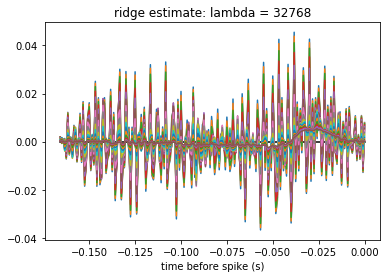

In [78]:
fig,axes=plt.subplots()

axes.plot(ttk,ttk*0,'k-')
for jj in range(nlam):
    
    # Compute ridge regression estimate
    w = lstsq(XXtr+lamvals[jj]*Imat,XYtr)[0]
    
    # Compute MSE
    msetrain[jj] = np.mean((spstrain-Xtrain@w)**2) # training error
    msetest[jj] = np.mean((spstest-Xtest@w)**2) # test error
    
    # store the filter
    w_ridge[:,jj] = w
    
    # plot it
    axes.plot(ttk,w[1:])
    axes.set_title('ridge estimate: lambda = %d'%lamvals[jj])
    axes.set_xlabel('time before spike (s)') 

note that the esimate "shrinks" down as we increase lambda

Plot filter estimates and errors for ridge estimates

Text(0.5, 1.0, 'best ridge estimate')

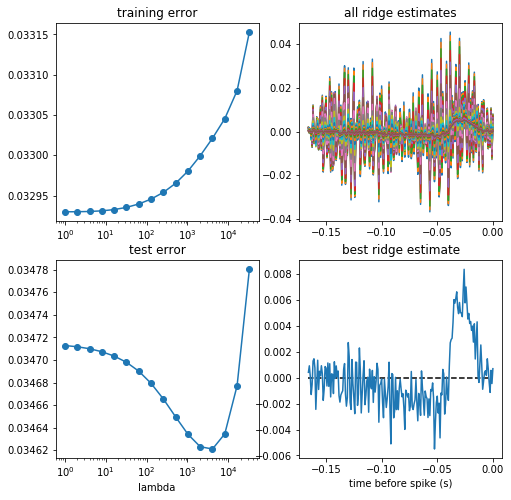

In [82]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(8,8))
axes[0,1].plot(ttk,w_ridge[1:,:])
axes[0,1].set_title('all ridge estimates')
axes[0,0].semilogx(lamvals,msetrain,'o-')
axes[0,0].set_title('training error')
axes[1,0].semilogx(lamvals,msetest,'o-')
axes[1,0].set_title('test error')
axes[1,0].set_xlabel('lambda')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(msetest)
filt_ridge= w_ridge[1:,imin]

axes[1,1].plot(ttk,ttk*0, 'k--')
axes[1,1].plot(ttk,filt_ridge)
axes[1,1].set_xlabel('time before spike (s)')
axes[1,1].set_title('best ridge estimate')

# L2 smoothing: linear-Gaussian model

Now let's instead instead try putting a penalty (or prior) on the squared
differences between filter coefficients. This penalize large jumps in the
filter, encouraging smoothness.

First, we need to make a matrix $D$ such that $w' D w$ computes the squared
differences. We can do this fairly easy as follows:

This matrix computes differences between adjacent coeffs

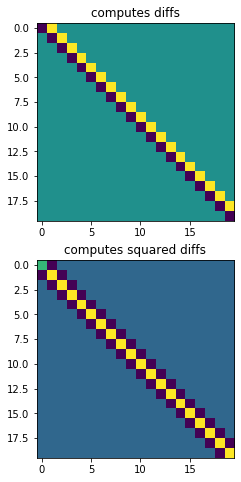

In [110]:
Dx1 = (np.diag(-np.ones(ntfilt),0)+np.diag(np.ones(ntfilt-1),1))[:-1,:]
Dx = Dx1.T@Dx1 # computes squared diffs

fig,axes=plt.subplots(nrows=2,figsize=(8,8))
axes[0].imshow(Dx1[:20,:20])
axes[0].set_title('computes diffs')

axes[1].imshow(Dx[:20,:20])
axes[1].set_title('computes squared diffs')

Let's just check to be sure

In [112]:
x = np.random.randn(ntfilt,1) # make random filter
print('sum of squared diffs, direct way: %.2f\n'%np.sum(np.diff(x)**2))
print('sum of squared diffs, matrix way: %.2f\n'%(x.T@Dx@x))

sum of squared diffs, direct way: 0.00

sum of squared diffs, matrix way: 368.22



Select smoothing penalty by cross-validation 

Now let's do exactly what we did with a grid of lambda values, only
instead of a scaled identity matrix we'll be using a scaled version of
the 'Dx' matrix.

Set up grid of lambda values (ridge parameters)

In [113]:
lamvals = 2.**np.arange(5,23) # it's common to use a log-spaced set of values
nlam = len(lamvals)

Embed Dx matrix in matrix with one extra row/column for constant coeff

In [116]:
D = block_diag(0,Dx)

Allocate space for train and test errors

<ipython-input-122-e1681e349b36>:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = lstsq((XXtr+lamvals[jj]*D),XYtr)[0]


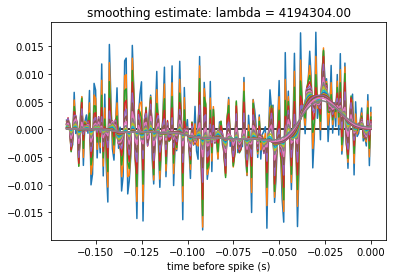

In [122]:
msetrain_sm = np.zeros(nlam)  # training error
msetest_sm = np.zeros(nlam)   # test error
w_smooth = np.zeros((ntfilt+1,nlam)) # filters for each lambda

# Now compute MAP estimate for each ridge parameter
fig,axes=plt.subplots()
axes.plot(ttk,ttk*0,'k-')
for jj in range(nlam):
    
    # Compute ridge regression estimate
    w = lstsq((XXtr+lamvals[jj]*D),XYtr)[0]
    
    # Compute MSE
    msetrain_sm[jj] = np.mean((spstrain-Xtrain@w)**2) # training error
    msetest_sm[jj] =  np.mean((spstest-Xtest@w)**2) # test error
    
    # store the filter
    w_smooth[:,jj] = w
    
    # plot it
    axes.plot(ttk,w[1:]) 
    axes.set_title('smoothing estimate: lambda = %.2f'%lamvals[jj])
    axes.set_xlabel('time before spike (s)')
    
# Note that the esimate becomes smoother as lambda increases.

Plot filter estimates and errors for smoothing estimates

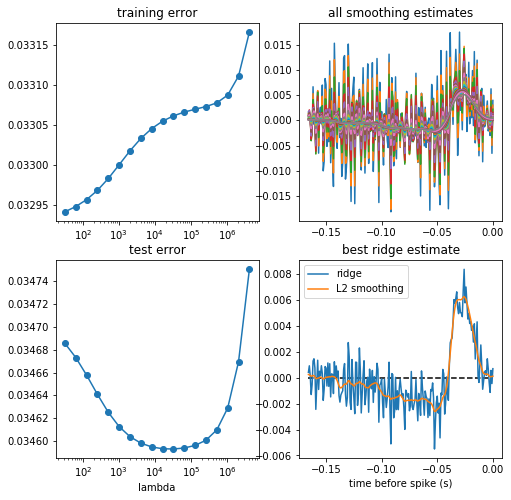

In [127]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(8,8))
axes[0,1].plot(ttk,w_smooth[1:,:])
axes[0,1].set_title('all smoothing estimates')
axes[0,0].semilogx(lamvals,msetrain_sm,'o-')
axes[0,0].set_title('training error')
axes[1,0].semilogx(lamvals,msetest_sm,'o-')
axes[1,0].set_title('test error')
axes[1,0].set_xlabel('lambda')

# Notice that training error gets monotonically worse as we increase lambda
# However, test error has an dip at some optimal, intermediate value.

# Determine which lambda is best by selecting one with lowest test error 
imin = np.argmin(msetest)
filt_smooth= w_smooth[1:,imin]

axes[1,1].plot(ttk,ttk*0, 'k--') 
axes[1,1].plot(ttk,filt_ridge,label='ridge')
axes[1,1].plot(ttk,filt_smooth,label='L2 smoothing')
axes[1,1].set_xlabel('time before spike (s)')
axes[1,1].set_title('best ridge estimate')
axes[1,1].legend()

# clearly the "L2 smoothing" filter looks better by eye!


Last, lets see which one actually achieved lower test error

In [129]:
print('\nBest ridge test error:      %.5f'%min(msetest))
print('Best smoothing test error:  %.5f'%min(msetest_sm))


Best ridge test error:      0.03462
Best smoothing test error:  0.03459


These differences are pretty puny for this dataset, but they are
greater if we examine Poisson-GLM log-likelihood instead of the
linear-Gaussian model considered here. (See tutorial4).